In [2]:
import itertools
import numpy as np
import pandas as pd
import ds_charts as ds
from datetime import datetime
import matplotlib.pyplot as plt
from seaborn import distplot,heatmap
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

In [6]:
#register_matplotlib_converters()
#Definição variáveis iniciais

read_file = pd.read_excel ("XAI - Freq.xlsx")
read_file.to_csv ("XAI - Freq.csv", index = None,header=True)

file = "XAI - Freq.csv"
tc = "surgycal margin" 
data = pd.read_csv(file,index_col=tc,na_values='')
df = pd.DataFrame(data)
data.shape
data.dtypes

Age.at.MRI                                     float64
Prostate.volume                                  int64
PSA.value.at.MRI                               float64
Index.lesion.PIRADS.V2                           int64
Index.lesion.size                                int64
Capsular.contact.lenght_TLC                      int64
Smooth.capsular.bulging                          int64
Capsular.disruption                              int64
Unsharp.margin                                   int64
Irregular.contour                                int64
Black.estrition.periprostatic.fat                int64
Retoprostatic.angle.obliteration                 int64
Measurable.ECE                                   int64
ECE.in.prostatectomy.specimen_gold.standard      int64
Gleason.score (binary variable)                  int64
regra                                            int64
dtype: object

In [7]:
#Tipos de variável
def get_variable_types(df):
    NR_SYMBOLS = 10
    variable_types = {'binary': [], 'numeric': [], 'date': [], 'symbolic': []}
    for c in df.columns:
        mv = df[c].isna().sum()
        uniques = df[c].unique()
        if mv == 0:
            if len(uniques) == 2:
                variable_types['binary'].append(c)
                df[c].astype('bool')
            elif df[c].dtype == 'datetime64':
                variable_types['date'].append(c)
            elif len(uniques) < NR_SYMBOLS:
                df[c].astype('category')
                variable_types['symbolic'].append(c)
            else:
                variable_types['numeric'].append(c)
        else:
            uniques = [v for v in uniques if not np.isnan(v)]
            values = [v for v in uniques if isinstance(v,str)]
            if len(uniques) == 2:
                variable_types['binary'].append(c)
            elif len(values) == len(uniques):
                df[c].astype('category')
                variable_types['symbolic'].append(c)
            else:
                values = [v for v in uniques if isinstance(v, datetime)]
                if len(values) == len(uniques):
                    variable_types['date'].append(c)
                else:
                    variable_types['numeric'].append(c)
    return variable_types

{'binary': ['Smooth.capsular.bulging', 'Capsular.disruption', 'Unsharp.margin', 'Irregular.contour', 'Black.estrition.periprostatic.fat', 'Retoprostatic.angle.obliteration', 'Measurable.ECE', 'ECE.in.prostatectomy.specimen_gold.standard', 'Gleason.score (binary variable)', 'regra'], 'numeric': ['Age.at.MRI', 'Prostate.volume', 'PSA.value.at.MRI', 'Index.lesion.size', 'Capsular.contact.lenght_TLC'], 'date': [], 'symbolic': ['Index.lesion.PIRADS.V2']}


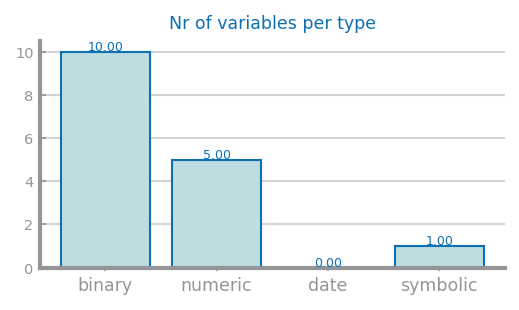

In [8]:
#Cálculo das variáveis
variable_types = get_variable_types(data)
print(variable_types)
counts = {}
for tp in variable_types.keys():
    counts[tp] = len(variable_types[tp])
plt.figure(figsize=(4,2))
ds.bar_chart(list(counts.keys()), list(counts.values()), title='Nr of variables per type')
#plt.savefig('Images/variable_types.png')
plt.show()

In [9]:
#Tipos das variáveis
binary_vars = variable_types['binary']
numeric_vars = variable_types['numeric']
symbolic_vars = variable_types['symbolic']

IndexError: list index out of range

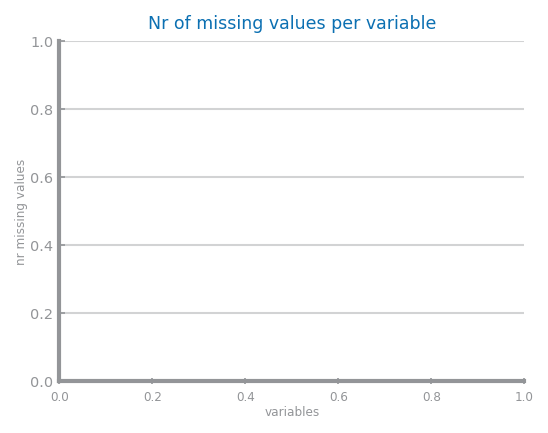

In [10]:
#Cálculo dos missing values
mv = {}
for var in data:
    nr = data[var].isna().sum()
    if nr > 0:
        mv[var] = nr
plt.figure()
ds.bar_chart(list(mv.keys()), list(mv.values()), title='Nr of missing values per variable',xlabel='variables', ylabel='nr missing values', rotation=True)
#plt.savefig('images/mv.png')
plt.show()

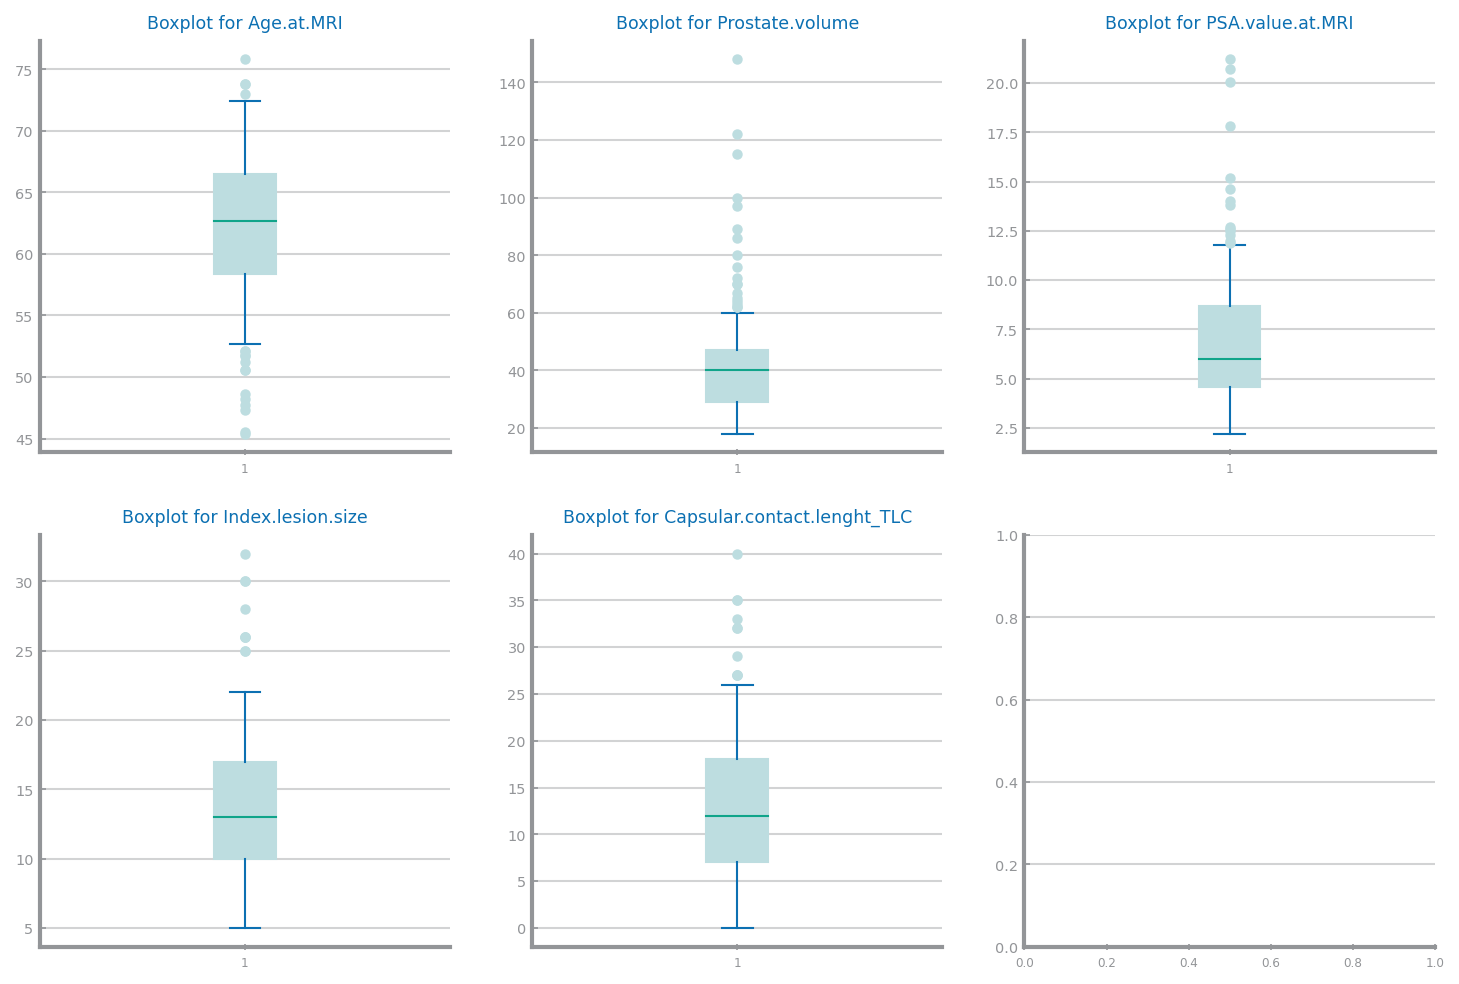

In [11]:
#Boxplot das variáveis numéricas
rows, cols = ds.choose_grid(len(numeric_vars))
fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT), squeeze=False)
i, j = 0, 0
for n in range(len(numeric_vars)):
    axs[i, j].set_title('Boxplot for %s'%numeric_vars[n])
    axs[i, j].boxplot(data[numeric_vars[n]].dropna().values)
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
#plt.savefig('images/single_boxplots.png')
plt.show()

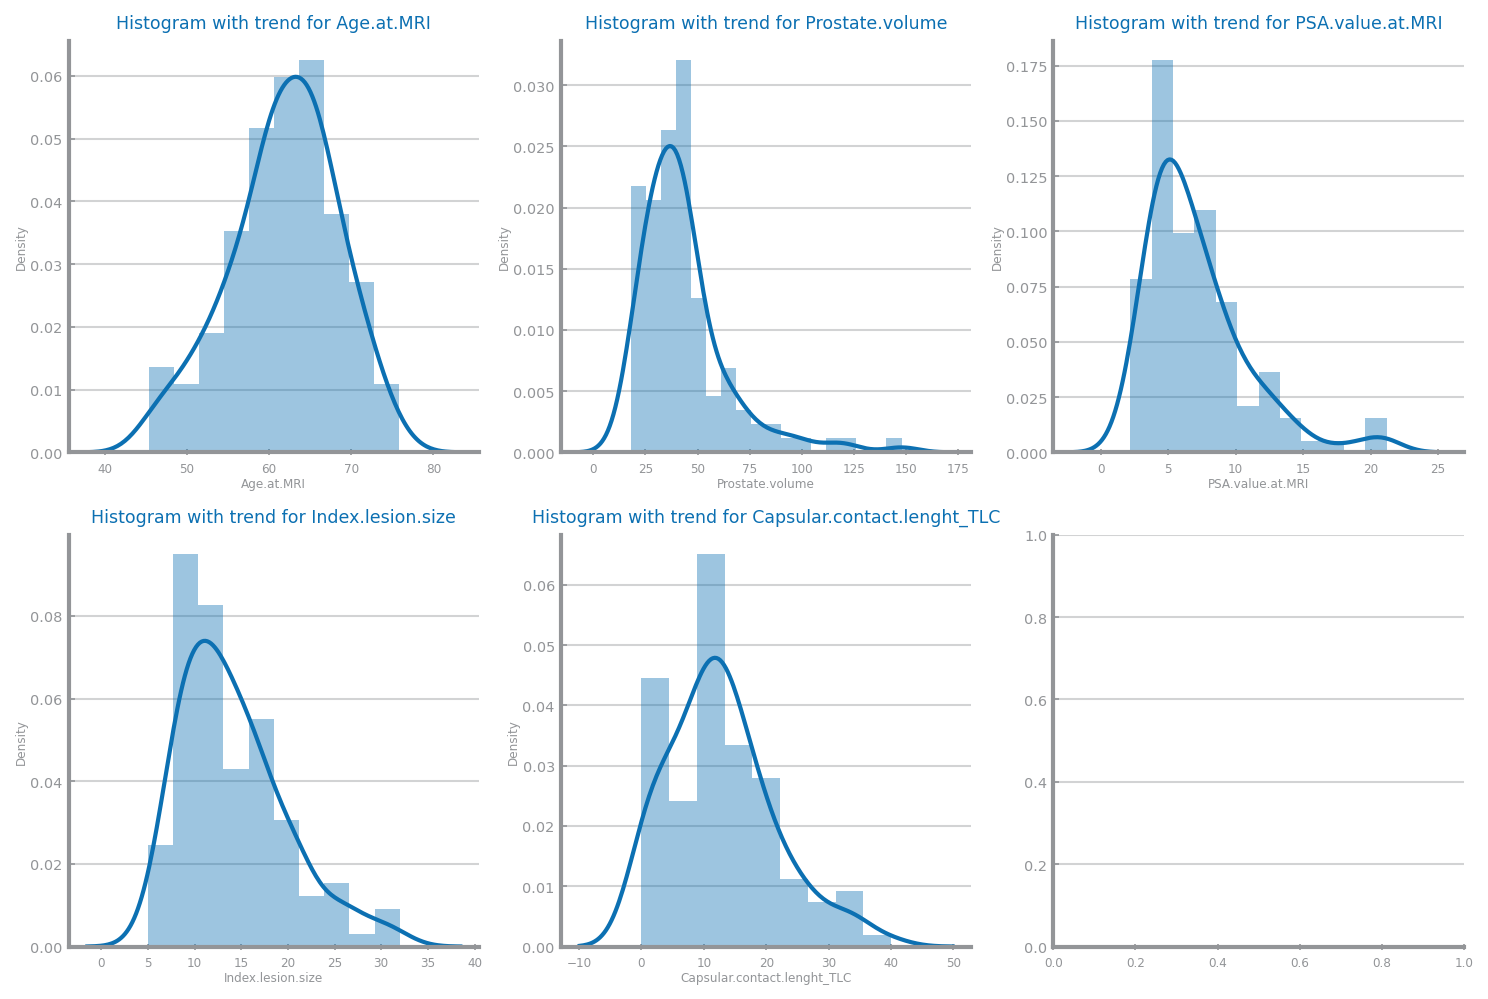

In [26]:
#Histogramas das variáveis numéricas com trendlines
fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT), squeeze=False)
i, j = 0, 0
for n in range(len(numeric_vars)):
    axs[i, j].set_title('Histogram with trend for %s'%numeric_vars[n])
    distplot(data[numeric_vars[n]].dropna().values, norm_hist=True, ax=axs[i, j], axlabel=numeric_vars[n])
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
#plt.savefig('images/histograms_trend_numeric.png')
plt.show()

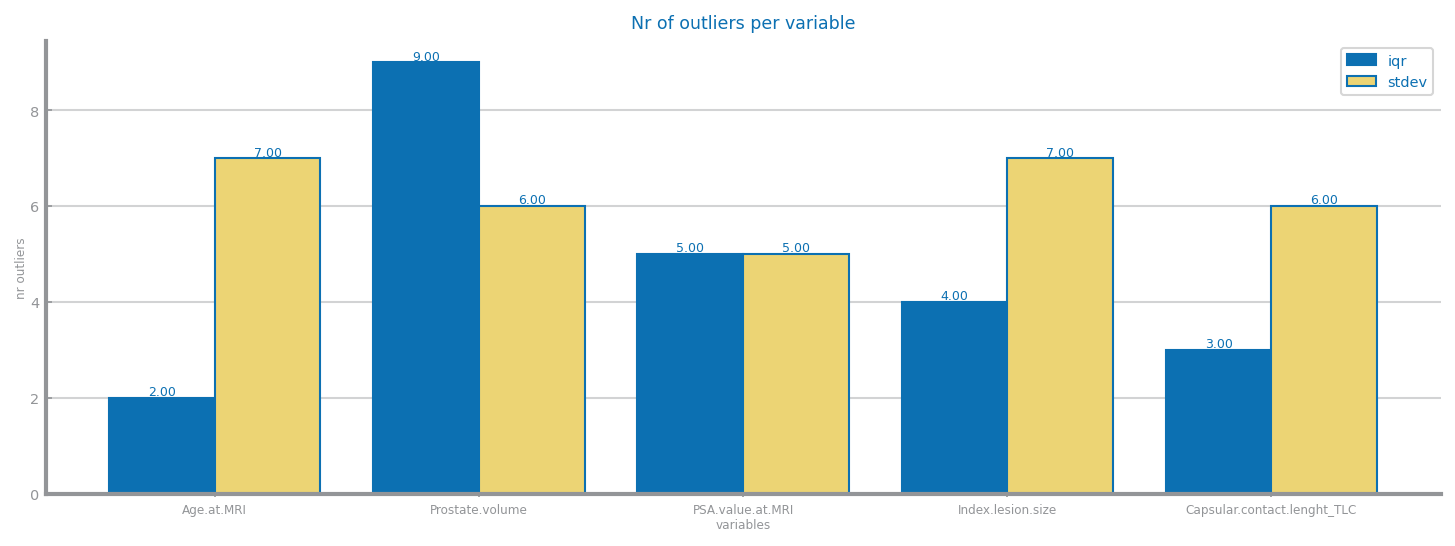

In [23]:
#Verificação dos outliers usandos os critérios de IQR e stdev
NR_STDEV: int = 2
outliers_iqr = []
outliers_stdev = []
summary5 = data.describe(include='number')
for var in numeric_vars:
    iqr = 1.5 * (summary5[var]['75%'] - summary5[var]['25%'])
    outliers_iqr += [
        data[data[var] > summary5[var]['75%']  + iqr].count()[var] +
        data[data[var] < summary5[var]['25%']  - iqr].count()[var]]
    std = NR_STDEV * summary5[var]['std']
    outliers_stdev += [
        data[data[var] > summary5[var]['mean'] + std].count()[var] +
        data[data[var] < summary5[var]['mean'] - std].count()[var]]
outliers = {'iqr': outliers_iqr, 'stdev': outliers_stdev}
plt.figure(figsize=(12, ds.HEIGHT))
ds.multiple_bar_chart(numeric_vars, outliers, title='Nr of outliers per variable', xlabel='variables', ylabel='nr outliers', percentage=False)
#plt.savefig('images/outliers.png')
plt.show()

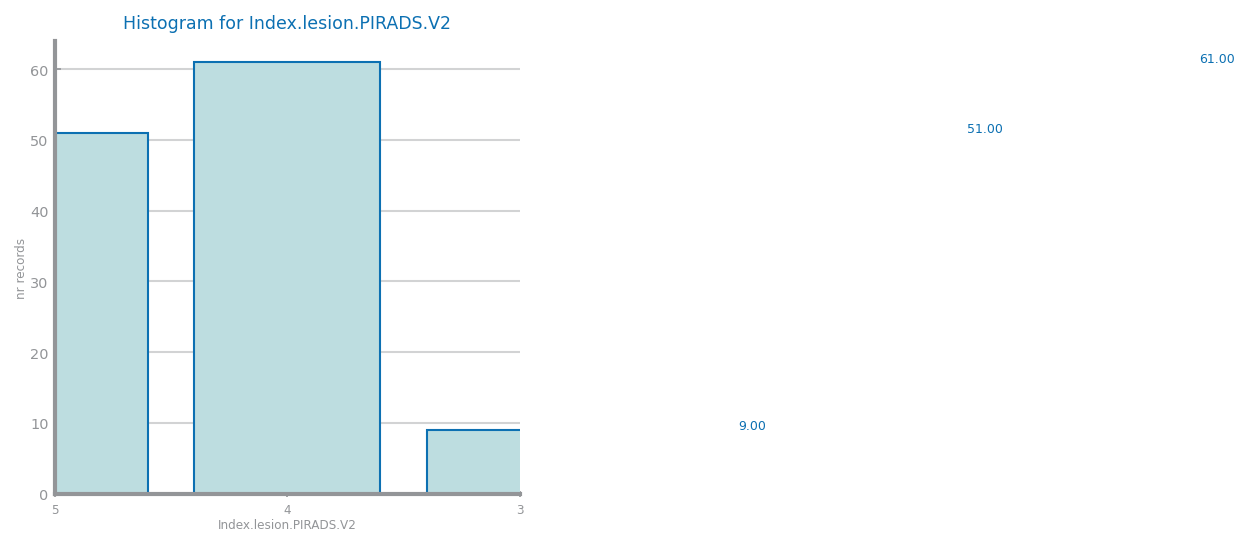

In [12]:
#Variáveis Simbólicas
rows, cols = ds.choose_grid(len(symbolic_vars))
fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT), squeeze=False)
i, j = 0, 0
for n in range(len(symbolic_vars)):
    counts = data[symbolic_vars[n]].value_counts()
    ds.bar_chart(counts.index.to_list(), counts.values, ax=axs[i, j], title='Histogram for %s'%symbolic_vars[n], xlabel=symbolic_vars[n], ylabel='nr records', percentage=False)
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
plt.savefig('images/histograms_symbolic.png')
plt.show()

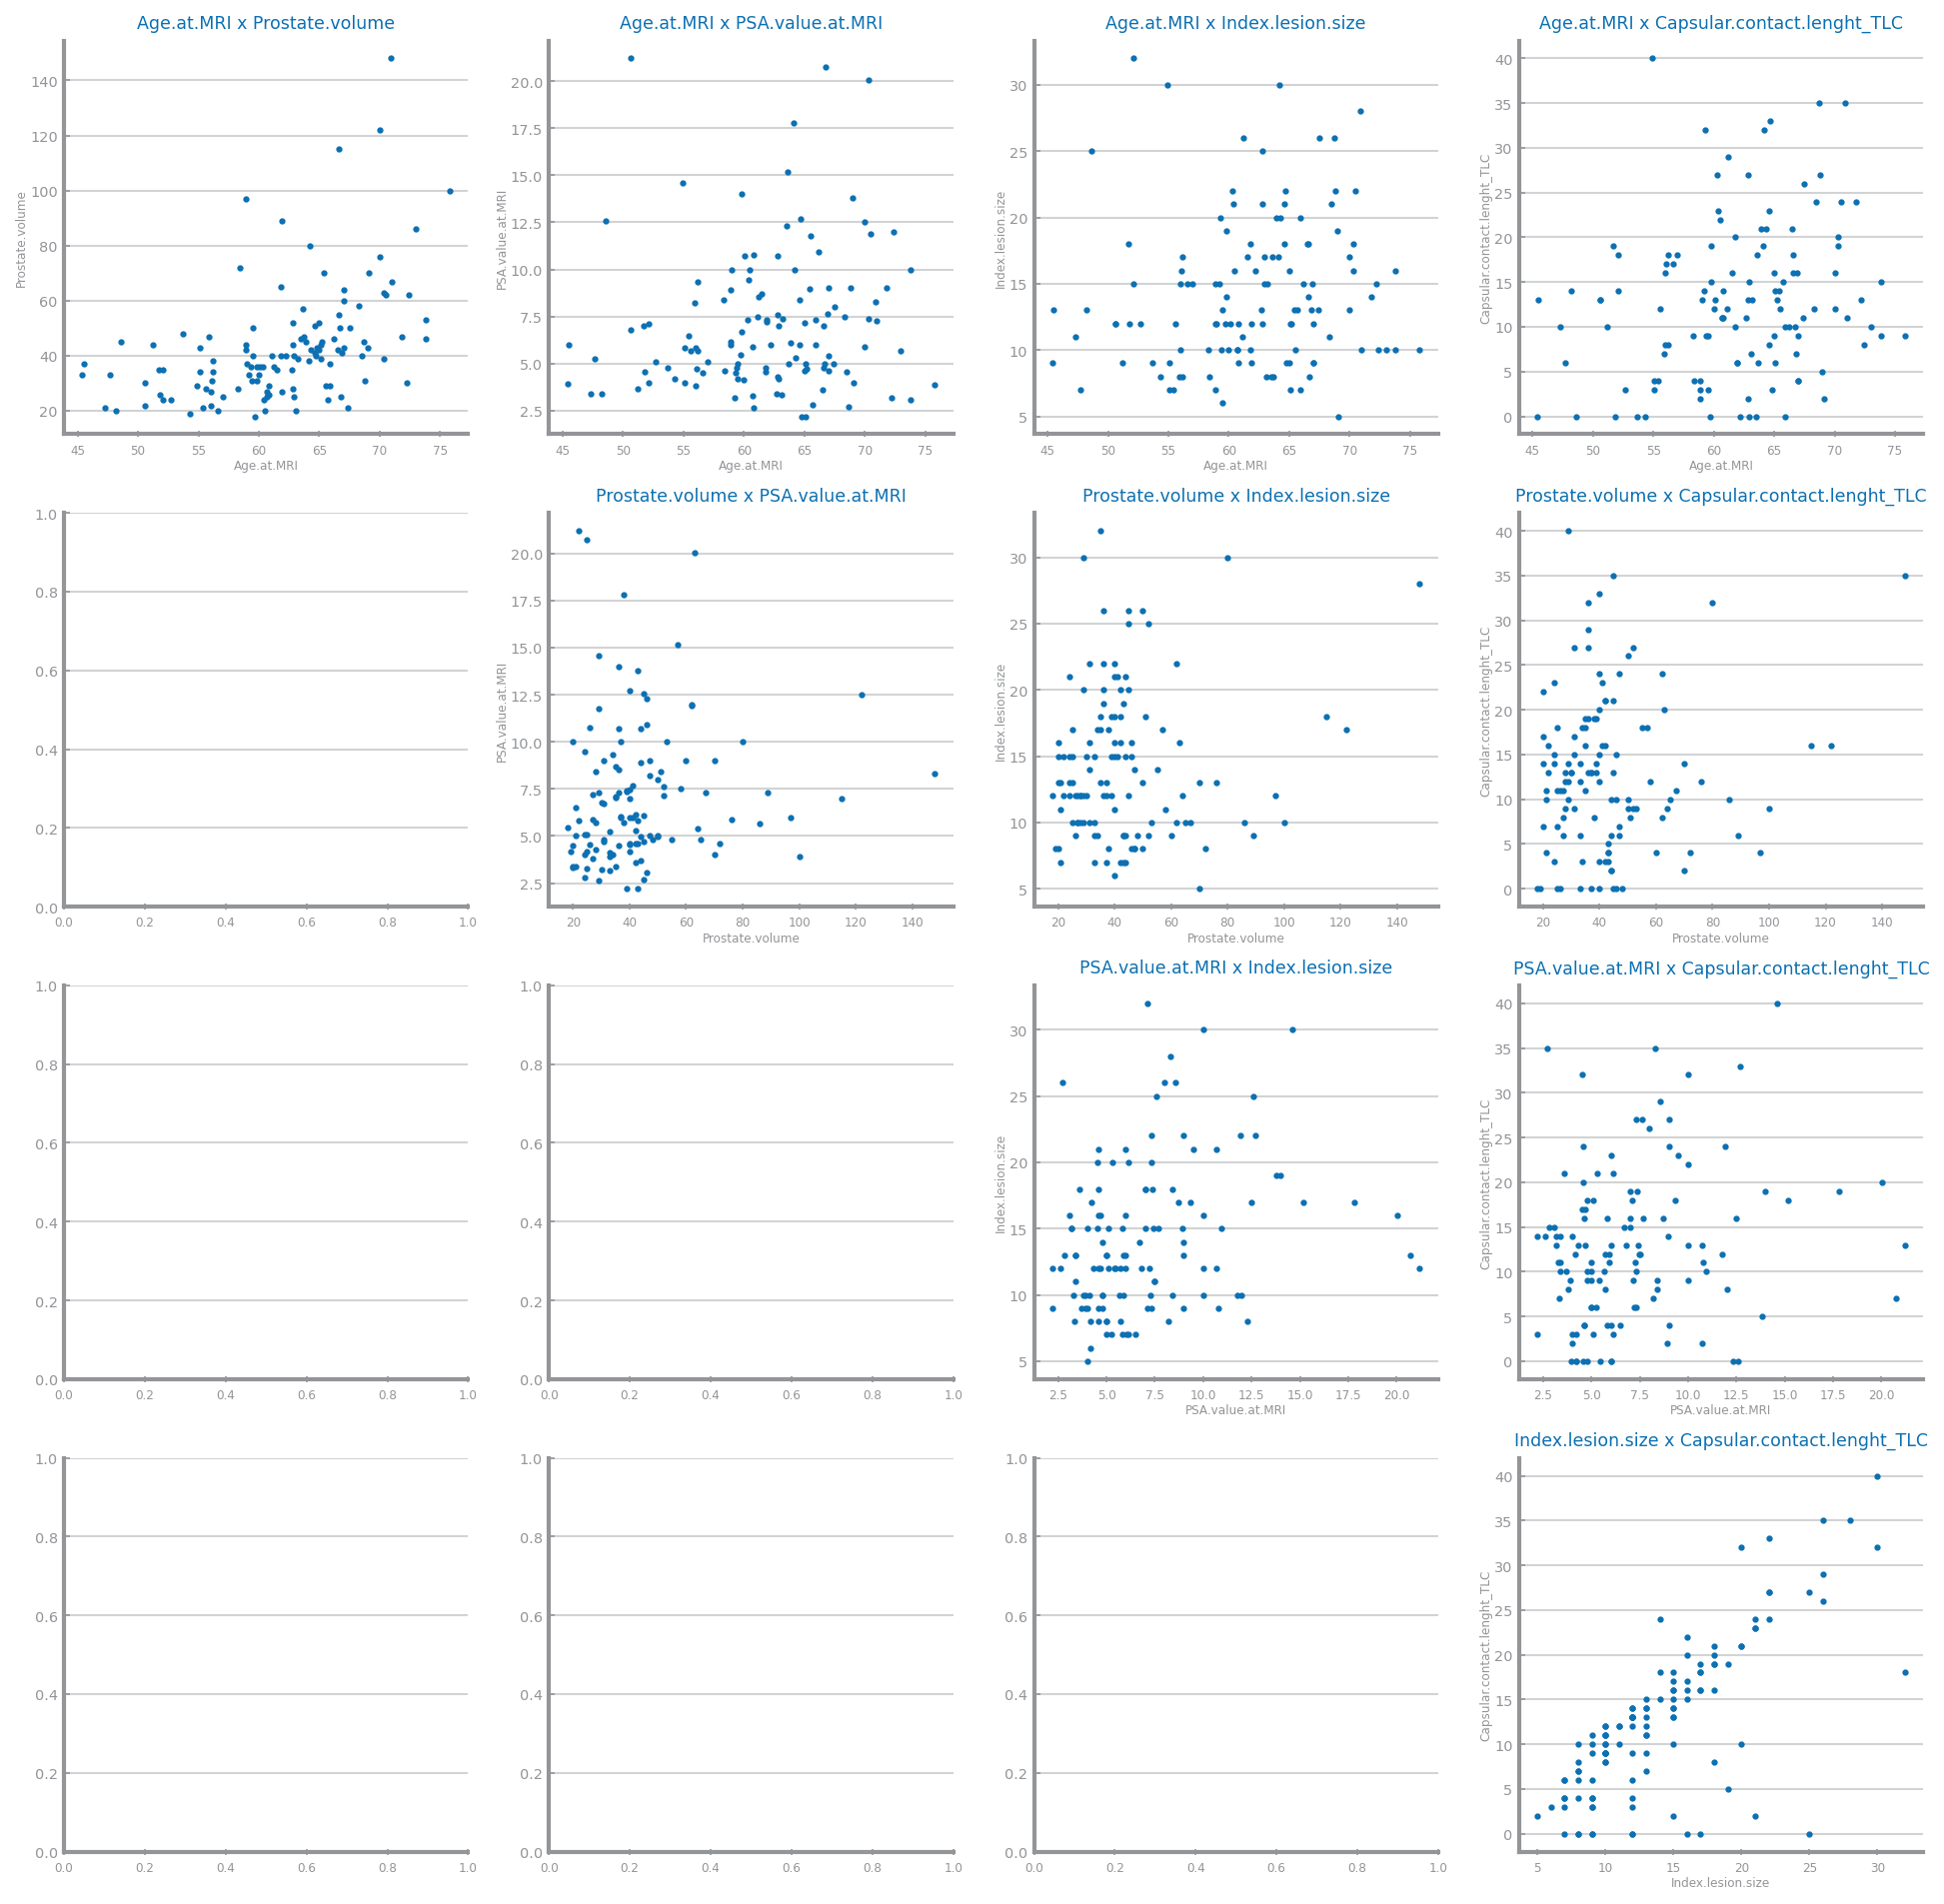

In [35]:
#Análise da sparsity - variáveis numéricas
rows, cols = len(numeric_vars)-1, len(numeric_vars)-1
fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT), squeeze=False)
for i in range(len(numeric_vars)):
    var1 = numeric_vars[i]
    for j in range(i+1, len(numeric_vars)):
        var2 = numeric_vars[j]
        axs[i, j-1].set_title("%s x %s"%(var1,var2))
        axs[i, j-1].set_xlabel(var1)
        axs[i, j-1].set_ylabel(var2)
        axs[i, j-1].scatter(data[var1], data[var2])
plt.savefig(f'images/sparsity_study_numeric.png')
plt.show()

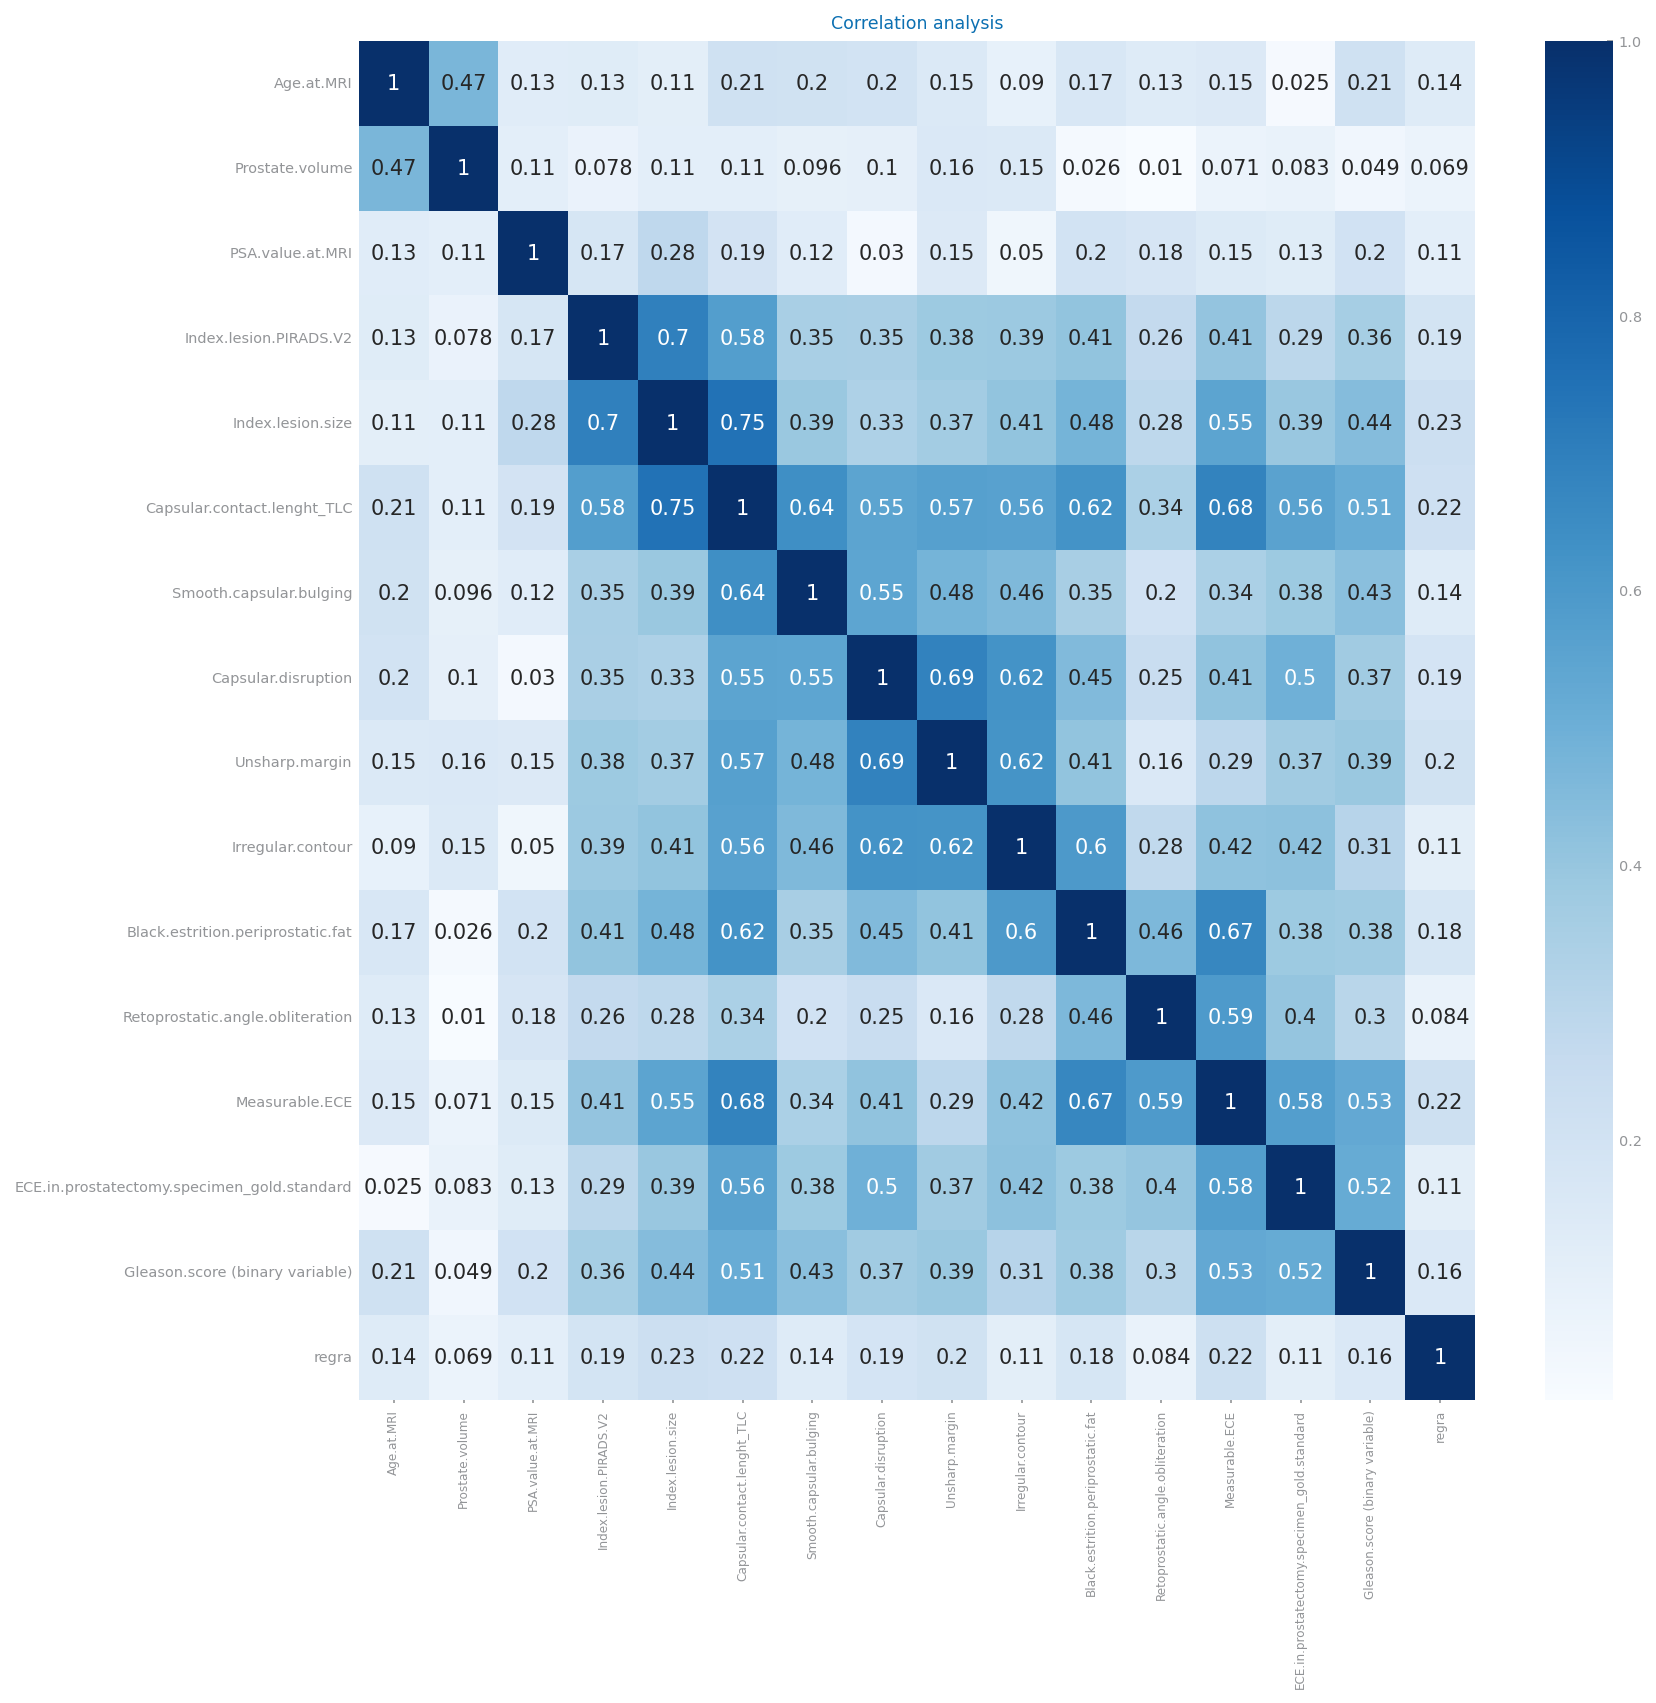

In [13]:
#Análise correlacional - heatmap
corr_mtx = abs(data.corr())
#print(corr_mtx)

fig = plt.figure(figsize=[12, 12])
heatmap(abs(corr_mtx), xticklabels=corr_mtx.columns, yticklabels=corr_mtx.columns, annot=True, cmap='Blues')
plt.title('Correlation analysis')
plt.savefig(f'images/correlation_analysis.png')
plt.show()

In [17]:
#Separação Teste/Treino
positive = 'P'
negative = 'N'
dataD: pd.DataFrame = pd.read_csv(file)
values = {'Original': [len(dataD[dataD[tc] == positive]), len(dataD[dataD[tc] == negative])]}

y: np.ndarray = dataD.pop(tc).values
X: np.ndarray = dataD.values
labels: np.ndarray = pd.unique(y)
labels.sort()

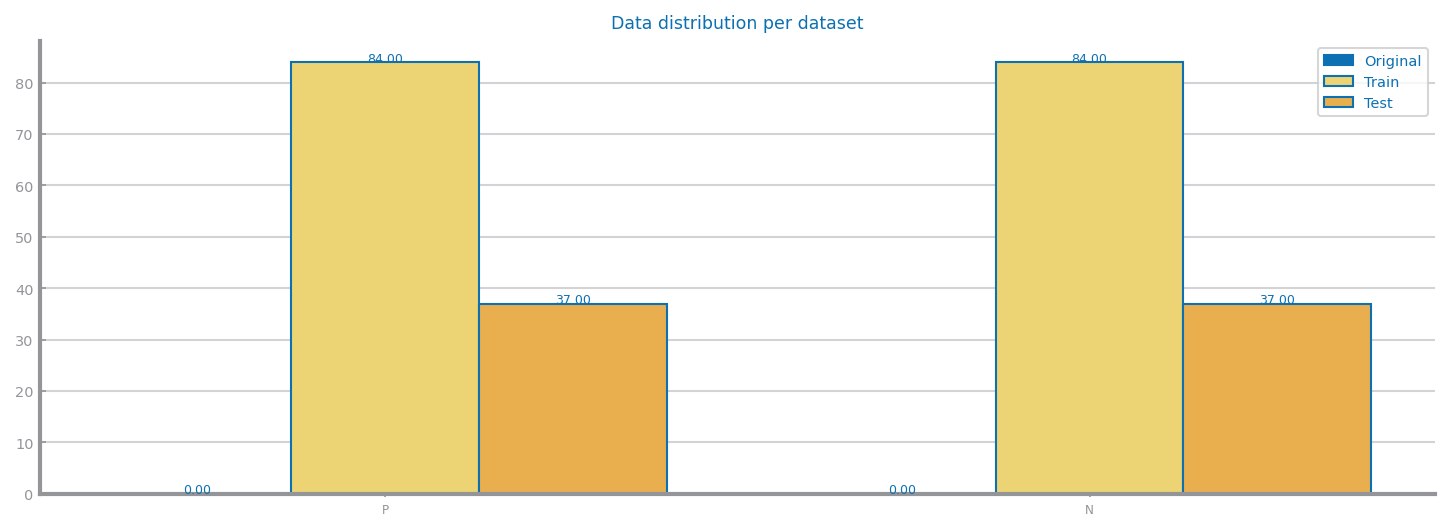

In [18]:
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

train = pd.concat([pd.DataFrame(trnX, columns=data.columns), pd.DataFrame(trnY,columns=[tc])], axis=1)
train.to_csv(f'{file}_train.csv', index=False)

test = pd.concat([pd.DataFrame(tstX, columns=data.columns), pd.DataFrame(tstY,columns=[tc])], axis=1)
test.to_csv(f'{file}_test.csv', index=False)
values['Train'] = [len(np.delete(trnY, np.argwhere(trnY==negative))), len(np.delete(trnY, np.argwhere(trnY==positive)))]
values['Test'] = [len(np.delete(tstY, np.argwhere(tstY==negative))), len(np.delete(tstY, np.argwhere(tstY==positive)))]

plt.figure(figsize=(12,4))
ds.multiple_bar_chart([positive, negative], values, title='Data distribution per dataset')
plt.show()

<Figure size 600x450 with 0 Axes>

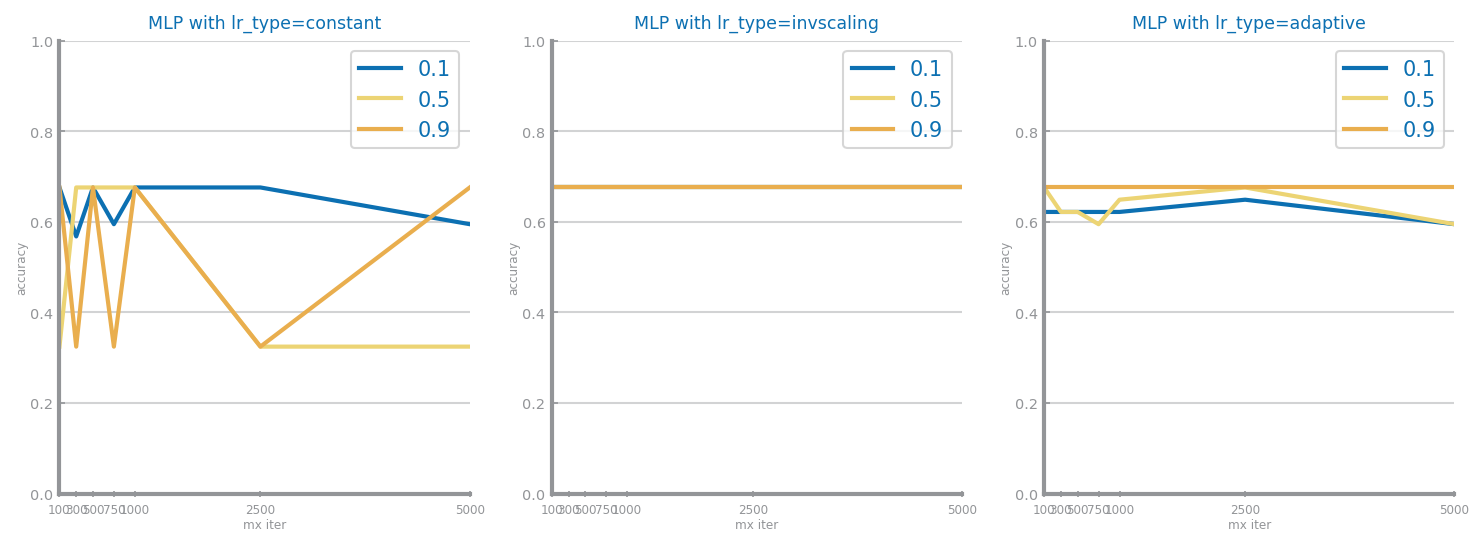

Best results with lr_type=constant, learning rate=0.1 and 100 max iter, with accuracy=0.6756756756756757


In [19]:
#Neural Networks
train: pd.DataFrame = pd.read_csv(f'{file}_train.csv')
trnY: np.ndarray = train.pop(tc).values
trnX: np.ndarray = train.values
labels = pd.unique(trnY)
labels.sort()

test: pd.DataFrame = pd.read_csv(f'{file}_test.csv')
tstY: np.ndarray = test.pop(tc).values
tstX: np.ndarray = test.values

lr_type = ['constant', 'invscaling', 'adaptive']
max_iter = [100, 300, 500, 750, 1000, 2500, 5000]
learning_rate = [.1, .5, .9]
best = ('', 0, 0)
last_best = 0
best_model = None

cols = len(lr_type)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(lr_type)):
    d = lr_type[k]
    values = {}
    for lr in learning_rate:
        yvalues = []
        for n in max_iter:
            mlp = MLPClassifier(activation='logistic', solver='sgd', learning_rate=d, learning_rate_init=lr, max_iter=n, verbose=False)
            mlp.fit(trnX, trnY)
            prdY = mlp.predict(tstX)
            yvalues.append(accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (d, lr, n)
                last_best = yvalues[-1]
                best_model = mlp
        values[lr] = yvalues
    ds.multiple_line_chart(max_iter, values, ax=axs[0, k], title=f'MLP with lr_type={d}',
                           xlabel='mx iter', ylabel='accuracy', percentage=True)
#plt.savefig(f'images/{file}_mlp_study.png')
plt.show()
print(f'Best results with lr_type={best[0]}, learning rate={best[1]} and {best[2]} max iter, with accuracy={last_best}')

<Figure size 600x450 with 0 Axes>

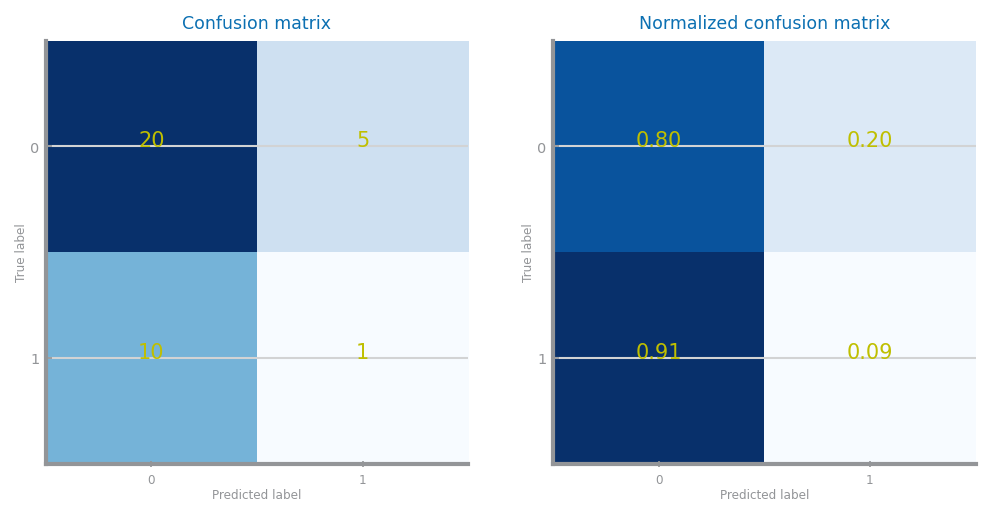

In [67]:
#Avaliação do modelo
clf = GaussianNB()
clf.fit(trnX, trnY)
clf.score(tstX, tstY)

labels: np.ndarray = pd.unique(y)
labels.sort()
prdY: np.ndarray = clf.predict(tstX)
cnf_mtx_tst: np.ndarray = confusion_matrix(tstY, prdY, labels=labels)
cnf_mtx_tst
CMAP = plt.cm.Blues

def plot_confusion_matrix(cnf_matrix: np.ndarray, classes_names: np.ndarray, ax: plt.Axes = None, normalize: bool = False):
    if ax is None:
        ax = plt.gca()
    if normalize:
        total = cnf_matrix.sum(axis=1)[:, np.newaxis]
        cm = cnf_matrix.astype('float') / total
        title = "Normalized confusion matrix"
    else:
        cm = cnf_matrix
        title = 'Confusion matrix'
    np.set_printoptions(precision=2)
    tick_marks = np.arange(0, len(classes_names), 1)
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes_names)
    ax.set_yticklabels(classes_names)
    ax.imshow(cm, interpolation='nearest', cmap=CMAP)

    fmt = '.2f' if normalize else 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt), color='y', horizontalalignment="center")

plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(8, 4), squeeze=False)
plot_confusion_matrix(cnf_mtx_tst, labels, ax=axs[0,0])
plot_confusion_matrix(cnf_mtx_tst, labels, axs[0,1], normalize=True)
plt.show()